Nombre de GPUs disponibles :  0


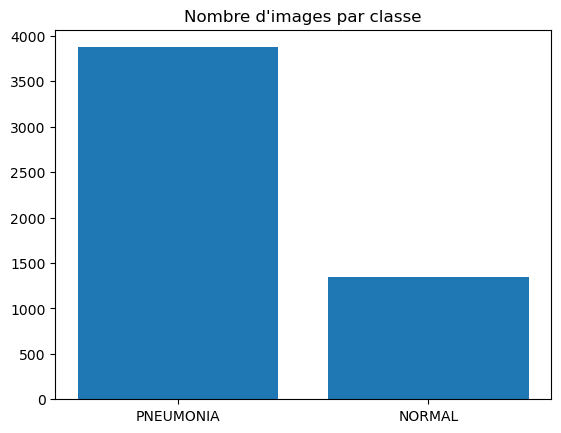

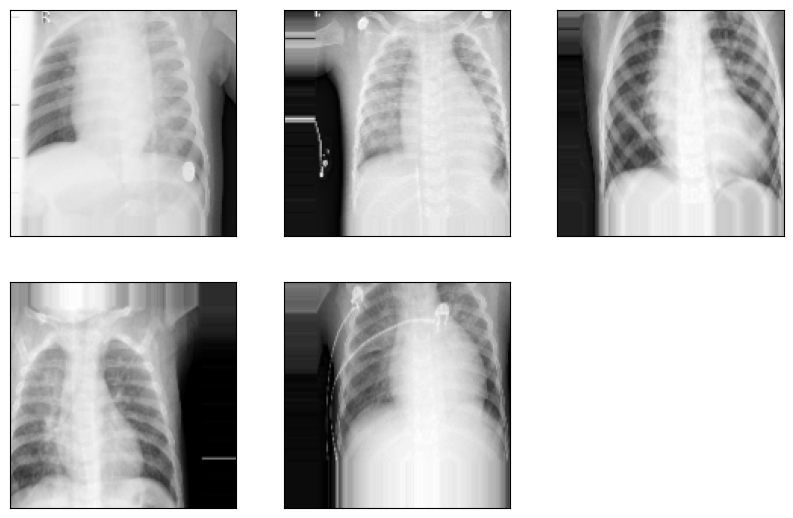

Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 90s 497ms/step - accuracy: 0.7102 - loss: 0.8338 - learning_rate: 0.0010
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 83s 494ms/step - accuracy: 0.7768 - loss: 0.4407 - learning_rate: 0.0010
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 78s 470ms/step - accuracy: 0.8268 - loss: 0.3733 - learning_rate: 0.0010
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 78s 471ms/step - accuracy: 0.8690 - loss: 0.3037 - learning_rate: 0.0010
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 80s 481ms/step - accuracy: 0.8868 - loss: 0.2870 - learning_rate: 0.0010
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 78s 470ms/step - accuracy: 0.8890 - loss: 0.2605 - learning_rate: 0.0010
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 78s 473ms/step - accuracy: 0.9102 - loss: 0.2222 - learning_rate: 0.0010
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 78s 473ms/step - accuracy: 0.9154 - loss: 0.2078 - learning_rate: 0.0010
Epoch 9/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 78s 470ms/step - accuracy: 0.9187 - loss: 0.2129 - learn

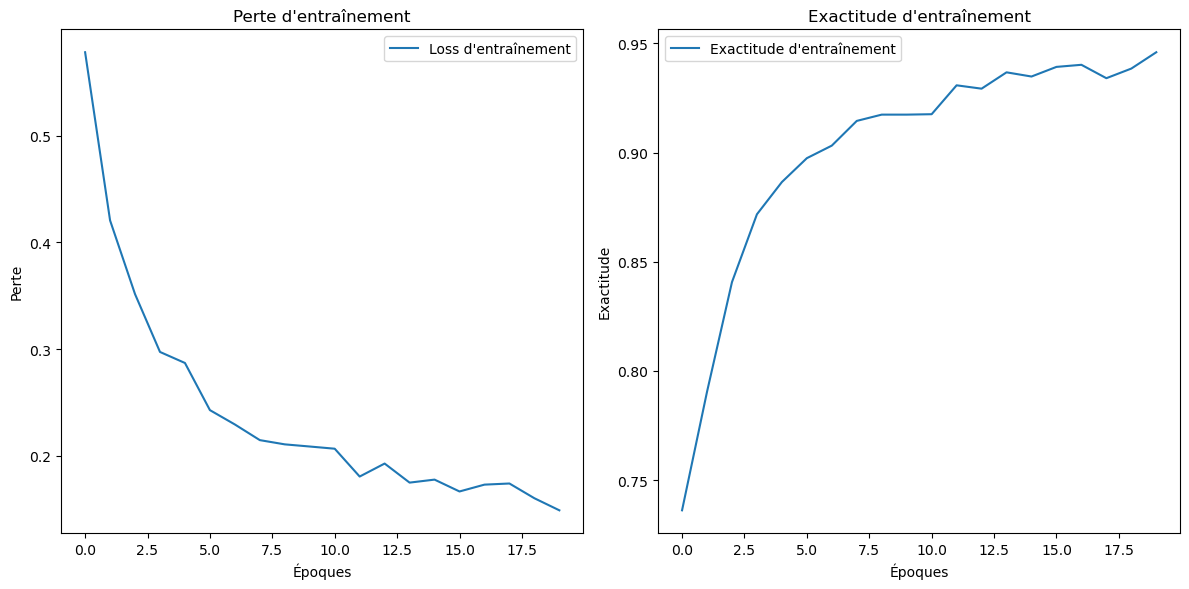

Exactitude du modèle : 95.55%
Perte du modèle : 0.1126
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 87ms/step


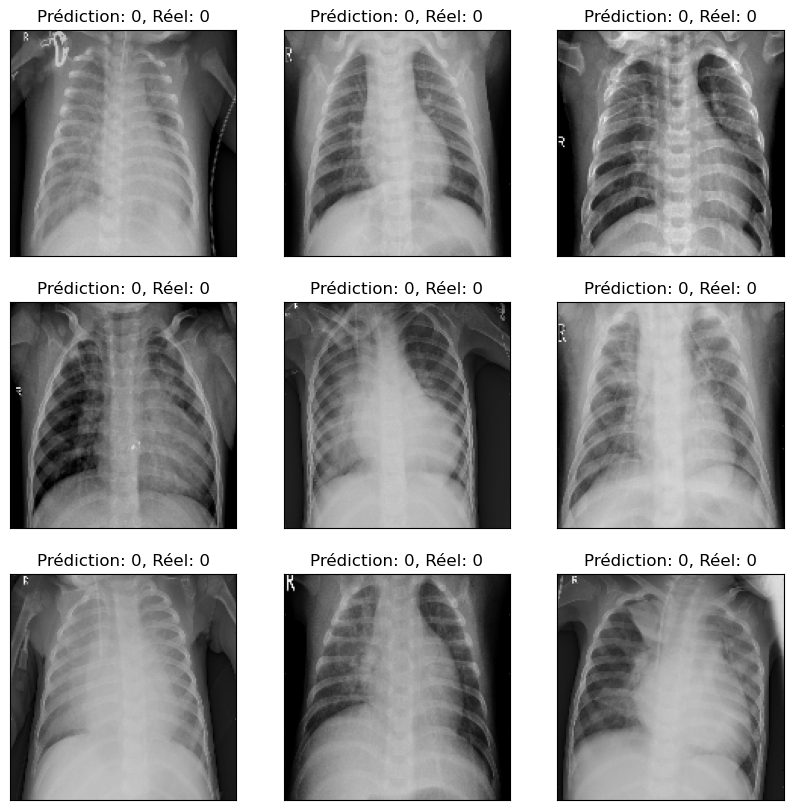

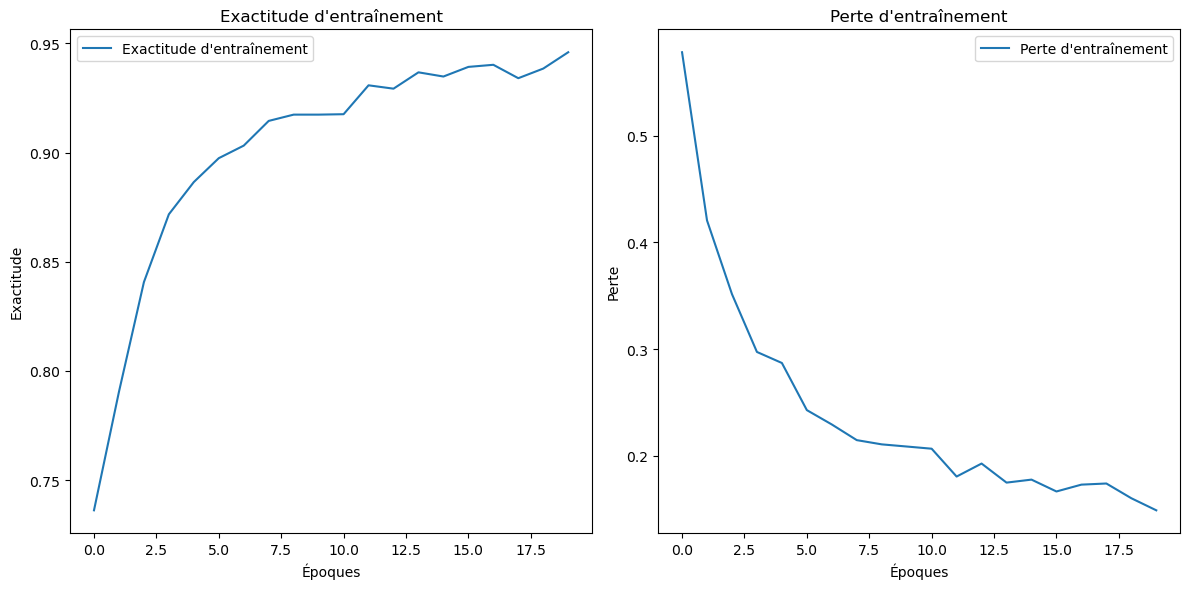

AttributeError: 'Sequential' object has no attribute 'predict_classes'

In [6]:
# Import des bibliothèques nécessaires
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Vérifier la disponibilité du GPU
print("Nombre de GPUs disponibles : ", len(tf.config.experimental.list_physical_devices('GPU')))

# Définir les constantes
img_size = 150
data_dir1 = '../../../chest_xray/train/PNEUMONIA'
data_dir2 = '../../../chest_xray/train/NORMAL'

# Fonction pour charger les données
def load_data(data_dir1, data_dir2):
    data = []
    labels = ['PNEUMONIA', 'NORMAL']
    for dir in [data_dir1, data_dir2]:
        path = os.path.join(dir)
        if not os.path.exists(path):
            print(f"Le répertoire {path} n'existe pas.")
            continue
        label = os.path.basename(dir)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                if img_arr is None:
                    print(f"Échec de lecture de {img}. Ignoré.")
                    continue
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype=object)

# Charger les données
train_data = load_data(data_dir1, data_dir2)

# Visualiser le nombre d'images par classe
labels_count = [0, 0]
for item in train_data:
    labels_count[item[1]] += 1

plt.bar(['PNEUMONIA', 'NORMAL'], labels_count)
plt.title('Nombre d\'images par classe')
plt.show()

# Séparer les features et les labels
def separate_features_labels(data):
    features, labels = [], []
    for feature, label in data:
        features.append(feature)
        labels.append(label)
    return np.array(features), np.array(labels)

x_train, y_train = separate_features_labels(train_data)

# Normaliser les données
x_train = x_train / 255.0
x_train = x_train.reshape(-1, img_size, img_size, 1)

# Assurer que les données ne sont pas vides
if x_train.size == 0 or y_train.size == 0:
    print("Les données d'entraînement sont vides. Veuillez vérifier le processus de chargement des données.")
else:
    # Augmentation complète des données avec décalage
    datagen = ImageDataGenerator(
        width_shift_range=0.2,
        height_shift_range=0.2,
        fill_mode='nearest'
    )
    datagen.fit(x_train)

    # Afficher quelques images augmentées
    def display_augmented_images(datagen, x_train, y_train):
        plt.figure(figsize=(10, 10))
        for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=5):
            for i in range(5):
                plt.subplot(330 + 1 + i)
                plt.xticks([])
                plt.yticks([])
                plt.imshow(x_batch[i].reshape(img_size, img_size), cmap='gray')
            plt.show()
            break

    display_augmented_images(datagen, x_train, y_train)

    # Définir le modèle
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 1)),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Callbacks pour ajuster le taux d'apprentissage et arrêter l'entraînement en cas de stagnation
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=2, min_lr=0.001)
    early_stop = EarlyStopping(monitor='loss', patience=3)

    # Entraîner le modèle avec les données augmentées
    history = model.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=20, callbacks=[reduce_lr, early_stop])

    # Fonction pour afficher les courbes d'apprentissage
    def plot_learning_curves(history):
        plt.figure(figsize=(12, 6))

        # Courbe de perte
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Loss d\'entraînement')
        plt.xlabel('Époques')
        plt.ylabel('Perte')
        plt.title('Perte d\'entraînement')
        plt.legend()

        # Courbe d'exactitude
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Exactitude d\'entraînement')
        plt.xlabel('Époques')
        plt.ylabel('Exactitude')
        plt.title('Exactitude d\'entraînement')
        plt.legend()

        plt.tight_layout()
        plt.show()

    # Afficher les courbes d'apprentissage
    plot_learning_curves(history)

    # Évaluation du modèle
    scores = model.evaluate(x_train, y_train, verbose=0)
    print(f"Exactitude du modèle : {scores[1]*100:.2f}%")
    print(f"Perte du modèle : {scores[0]:.4f}")

    # Fonction pour afficher les prédictions
    def display_predictions(model, x_train, y_train):
        plt.figure(figsize=(10, 10))
        predictions = (model.predict(x_train) > 0.5).astype("int32")
        for i in range(9):
            plt.subplot(330 + 1 + i)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(x_train[i].reshape(img_size, img_size), cmap='gray')
            plt.title(f"Prédiction: {predictions[i][0]}, Réel: {y_train[i]}")
        plt.show()

    display_predictions(model, x_train, y_train)

    # Afficher d'autres graphiques pertinents

    # Graphique d'exactitude et de perte sur les données d'entraînement
    plt.figure(figsize=(12, 6))

    # Exactitude
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Exactitude d\'entraînement')
    plt.title('Exactitude d\'entraînement')
    plt.xlabel('Époques')
    plt.ylabel('Exactitude')
    plt.legend()

    # Perte
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Perte d\'entraînement')
    plt.title('Perte d\'entraînement')
    plt.xlabel('Époques')
    plt.ylabel('Perte')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Matrice de confusion
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

    y_pred = model.predict_classes(x_train)
    cm = confusion_matrix(y_train, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['PNEUMONIA', 'NORMAL'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Matrice de confusion')
    plt.show()

    # Rapport de classification
    from sklearn.metrics import classification_report

    print(classification_report(y_train, y_pred, target_names=['PNEUMONIA', 'NORMAL']))